# Chapter 5 Assignment
In this assignment, you will be implementing a basic Convolutional Neural Network in order to classify images from the publicly available [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset is a subset of the larger CIFAR-100 dataset with only 10 unique image classes as opposed to 100. We encourage you to follow the hyperlink in to learn more about the dataset!

First of all, let's import the necessary modules.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Next, we want to import all of the data. When working with data, it is commonplace to find instructions with how to use and import the data. This happens to be the case with CIFAR-10 dataset. Scroll down to the "Dataset Layout" section on the website linked above and refer to the instructions for Python3 to fill in this part of the assignment. 

In [2]:
# TODO: Define the unpickle function below
# Note: Replace encoding='bytes' with encoding='latin1'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding = 'latin1')
    return dict

The website includes information about what is included in the dict that the unpickle function returns. Use that information to extract the data from the dict so that you have all of the data in numpy array format without the unnecessary meta information included in the dict. Also, since the train data is separated into batches, combine all of the batches so that you have freedom to use any number of batches later when you define the model.

In [3]:
# Location of the data files, feel free to modify if needed
data_dir = "./"

train_data_dirs = [data_dir+"data_batch_{}".format(i) for i in range(1,6)]

train_data = None
train_labels = None

# TODO: Unpickle each batch and combine the data from ever batch
# into the two numpy arrays train_data and train_labels
train_data = unpickle(train_data_dirs[0])['data']
train_labels = np.array(unpickle(train_data_dirs[0])['labels'])
for i in range(1,len(train_data_dirs)):
    train_data = np.concatenate((train_data, unpickle(train_data_dirs[i])['data']), axis = 0)
    train_labels = np.concatenate((train_labels, np.array(unpickle(train_data_dirs[i])['labels'])),\
                                 axis = 0)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.float32)
# Do not change these. If they are failing, you should revisit 
# how you combined all of the batches into one
assert train_data.shape == (50000, 3072)
assert train_labels.shape == (50000,)

In [4]:
test_data_dir = data_dir+"test_batch"

test_data = None
test_labels = None

# TODO: Unpickle test batch and set test_data and test_labels
# to the appropriate numpy arrays
test_data = np.array(unpickle(test_data_dir)['data'])
test_labels = np.array(unpickle(test_data_dir)['labels'])
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.float32)
# Do not change these. If they are failing, you should revisit 
# how you extracted the data from the test_batch file
assert test_data.shape == (10000, 3072)
assert test_labels.shape == (10000,)

In [5]:
meta_data_dir = data_dir+"batches.meta"

label_names = None

# TODO: Unpickle meta data and extract labels names 
label_names = unpickle(meta_data_dir)['label_names']

assert len(label_names) == 10

Since the values of each pixel for each color channel are in the range \[0,255\], this could cause problems with exploding gradients. To combat this, it would greatly help if the data were bounded in the range \[0,1\]. The technique you should implement for scaling down the data is called [Min Max Normalization](https://www.quora.com/What-is-the-meaning-of-min-max-normalization). Use the functions [np.min](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.minimum.html), and [np.max](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html) to complete this section. Here is a reference image for how Min Max Normalization is computed:
![image.png](attachment:image.png)

In [6]:
# TODO: Fill in the min max normalization function
def min_max_normalization(x):
    for i in range(len(x)):
        # For the red channel:
        red_min = np.min(x[i][:1024])
        red_max = np.max(x[i][:1024])
        for j in range(1024):
            x[i][j] = (x[i][j] - red_min) / (red_max - red_min)
            
        # For the green channel:
        green_min = np.min(x[i][1024:2048])
        green_max = np.max(x[i][1024:2048])
        for j in range(1024,2048):
            x[i][j] = (x[i][j] - green_min) / (green_max - green_min)
            
        # For the blue channel:
        blue_min = np.min(x[i][2048:])
        blue_max = np.max(x[i][2048:])
        for j in range(2048,3072):
            x[i][j] = (x[i][j] - blue_min) / (blue_max - blue_min)
    return x
    
    
train_data = min_max_normalization(train_data)
test_data = min_max_normalization(test_data)

We are now almost done preprocessing our data. As you can see, the the current dimensions of `train_data` and `test_data` are `(50000, 3072)` and `(10000, 3072)` respectively. This implies that every image is represented as a 1D vector of size 32\*32\*3 = 3072. This will not work for a CNN since the spatial relationship of the pixels is not preserved and the CNN expects an image with shape `(32, 32, 3)`. In this next part you will reshape `train_data` and `test_data` in order to reflect the more natural representation of an image.

Here are some useful functions to use when completing this part: [np.reshape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.reshape.html), [np.transpose](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.transpose.html)

Text(0.5, 1.0, 'frog')

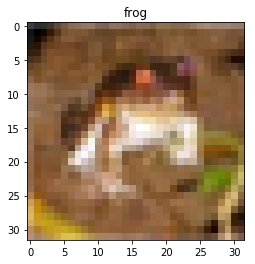

In [7]:
# TODO: Reshape the train and test data batches
def reshape_data(data):
    # Hint: Read the section "Dataset Layout" to understand how
    # the 1D array encodes the image to help you reshape it
    features = data.reshape((len(data)), 3, 32, 32).transpose(0, 2, 3, 1)
    return features

reshaped_train_data = reshape_data(train_data)
reshaped_test_data = reshape_data(test_data)


# Change the value of 'i' and see if the pictures resemble their labels
# Don't continue past this point if the images don't seem to resemble anything
i = 0
plt.imshow(reshaped_train_data[i])
plt.title(label_names[int(train_labels[i])])

Lastly, we want to one-hot encode the labels vector. If you are unfamiliar with one hot encoding, it essentially transforms categorical data into something more interpretable by classification models. Currently, each label for a given image is represented as a single number representing the index of the corresponding class out of the 10 possible classes. Thus, the value is categorical rather than quantitative. To fix this, we label each image with a vector of size 10 where each entry to the vector is 0 for all indices other than of the correct label. The code below demonstrates an example of that one-hot encoding would do to several examples.

In [8]:
a_label = 3
b_label = 5

a_one_hot_encoded_label = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
b_one_hot_encoded_label = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

Now we can train a model to predict the probability that an image is in a specific class for every one of the 10 classes. The true label that we would want to approach is predicting 0 for all classes except for the correct one where we want to predict 1. You can use the [keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function to encode the train and test labels.

In [9]:
# TODO: use keras.utils.to_categorical to one hot encode the train and test labels
one_hot_train = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
one_hot_test = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

assert one_hot_train.shape == (50000, 10)
assert one_hot_test.shape == (10000, 10)

We can now finally build the model itself. Refer to the DLP Chapter 5 notebooks for guidance on how to build a CNN using Sequential(). We have also provided some links to documentation of important layers you should be using in your CNN:
- [layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [layers.MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
- [layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
- [layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [10]:
def cnn_model():
    model = keras.models.Sequential()
    # TODO: Build the Convolutional portion of the model
    model.add(layers.Conv2D(64, (3, 3), input_shape=(32, 32, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # TODO: Flatten the output of the convolutional layers and
    # pass it to a fully connected network to predict the label vector
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))
    # Hint: Which activation function should be used in the final layer
    # so that the output of the model is a probability distribution?
    return model

model = cnn_model()

W0210 22:30:03.928844 140490426271552 deprecation.py:506] From /gpfs/data/data2040/tf2gpu2/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:148: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Finally, compile and fit the model it using the training data. You should use the following hyperparameters to to ensure consistency with our grading:
- __optimizer:__ "Adam"
- __loss:__ "categorical_crossentropy"
- __metrics:__ \["accuracy"\]

In [11]:
train_x = reshaped_train_data
train_y = one_hot_train

val_x = reshaped_test_data
val_y = one_hot_test

# TODO: Compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# TODO: Fit the model to the train data using model.fit
fit = model.fit(train_x, 
                train_y, 
                epochs = 8, 
                batch_size = 128,validation_data=(val_x, val_y))

Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000==============================] - 16s 320us/sample - loss: 1.7695 - acc: 0.3401 - val_loss: 1.3360 - val_acc: 0.5133
Epoch 2/8
50000/50000==============================] - 4s 71us/sample - loss: 1.3030 - acc: 0.5310 - val_loss: 1.1382 - val_acc: 0.6002
Epoch 3/8
50000/50000==============================] - 4s 72us/sample - loss: 1.1122 - acc: 0.6068 - val_loss: 1.0368 - val_acc: 0.6317
Epoch 4/8
50000/50000==============================] - 4s 73us/sample - loss: 0.9869 - acc: 0.6547 - val_loss: 0.9556 - val_acc: 0.6706
Epoch 5/8
50000/50000==============================] - 4s 71us/sample - loss: 0.8986 - acc: 0.6857 - val_loss: 0.8550 - val_acc: 0.7036
Epoch 6/8
50000/50000==============================] - 4s 73us/sample - loss: 0.8360 - acc: 0.7102 - val_loss: 0.8765 - val_acc: 0.6977
Epoch 7/8
50000/50000==============================] - 4s 71us/sample - loss: 0.7612 - acc: 0.7352 - val_loss: 0.8396 - val_acc: 0.7

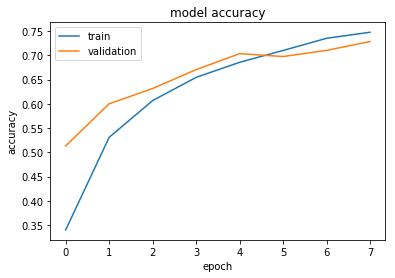

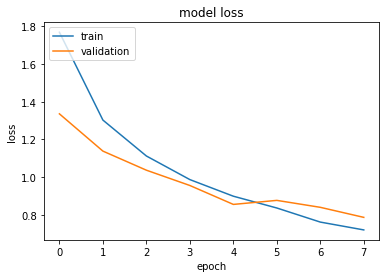

In [12]:
# Nothing to change here, this is to visualize your loss and accuracy
plt.plot(fit.history['acc'])
plt.plot(fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We will use the `accuracy` metric over the train and test sets in order to evaluate the preformance of your model. In the cell below, evaluate your accuracy on both sets and ensure that they are both above 70% and within 10% of each other. 

In [13]:
# TODO: Evaluate your model using model.evaluate
train_results = model.predict(train_x)
test_results = model.predict(val_x)

train_acc = model.evaluate(train_x, train_y)[1]
test_acc = model.evaluate(val_x, val_y)[1]

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("Both above 70%: ", train_acc >= 0.7 and test_acc >= 0.7)
print("Within 10% of each other: ", abs(train_acc-test_acc) <= 0.1)

50000/50000==============================] - 3s 66us/sample - loss: 0.5612 - acc: 0.8099
10000/10000==============================] - 1s 67us/sample - loss: 0.7862 - acc: 0.7286
Train Accuracy:  0.80986
Test Accuracy:  0.7286
Both above 70%:  True
Within 10% of each other:  True


In [14]:
# run this to print a summary of your model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [15]:
# Once you are done, run this to save the model
tf.keras.models.save_model(
    model,
    "./cnn.h5",
    overwrite=True,
    include_optimizer=True)